In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
angle = pd.read_excel('Angle.xls')
frequency = pd.read_excel('Frequency.xls')
voltage = pd.read_excel('Voltage Magnitude.xls')

# Loading Data

In [4]:
frequency.head()

,Timestamp,BADARPUR:Frequency
0,2021-09-11 06:12:16.840,50.008
1,2021-09-11 06:12:16.880,50.008
2,2021-09-11 06:12:16.920,50.009
3,2021-09-11 06:12:16.960,50.009
4,2021-09-11 06:12:17.000,50.008


# Frequency Analysis

<AxesSubplot:>

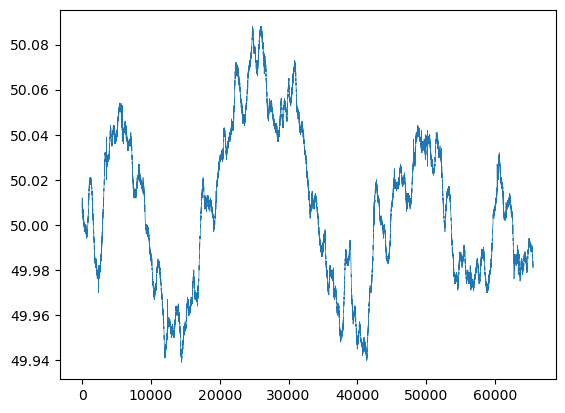

In [5]:
frequency['BADARPUR:Frequency'].plot(linewidth = 0.5)

In [6]:
freq2 = frequency['BADARPUR:Frequency'].copy()

In [7]:
freq_array = freq2.to_numpy()

In [8]:
##### code for denoising the data using fourier transform

In [9]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

# Wavelet denoising

In [10]:
from skimage.restoration import denoise_wavelet

<AxesSubplot:>

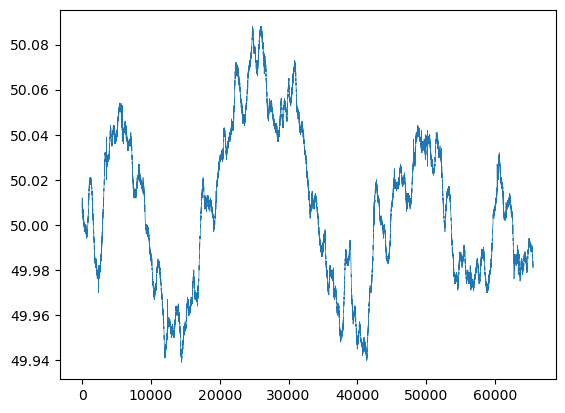

In [14]:
y = denoise_wavelet(freq_array, wavelet='db1', mode='soft', wavelet_levels=3, method='BayesShrink', rescale_sigma='True')


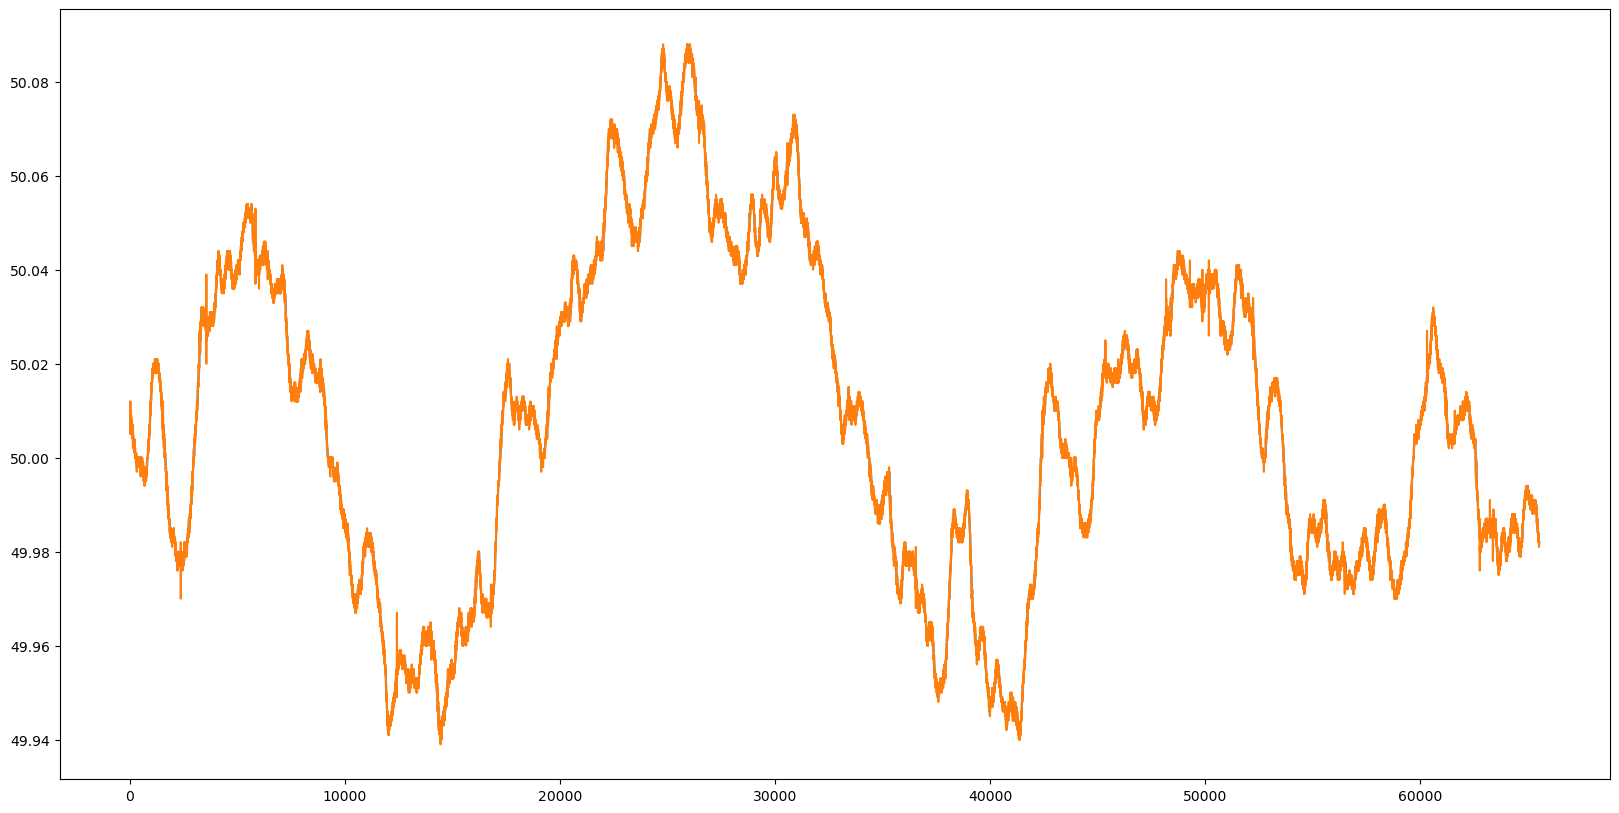

In [16]:
plt.figure(figsize=(20, 10), dpi=100)
plt.plot(y)
plt.plot(frequency['BADARPUR:Frequency'])
plt.show()


In [20]:
frequency['BADARPUR:Frequency'].shape

(65535,)

### Noise Induction

In [49]:
mu, sigma = 0, 0.001
noise = np.random.normal(mu, sigma, (65535,))

In [50]:
signal = frequency['BADARPUR:Frequency'] + noise

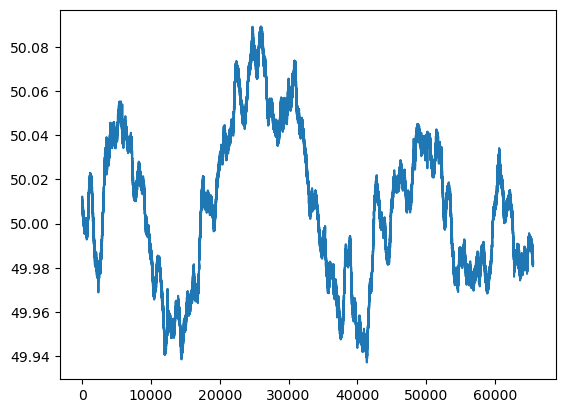

In [51]:
plt.plot(signal)

# Cleaning

## fft

In [27]:
fft_frequency = fft_denoiser(signal, 00.1, to_real=True)

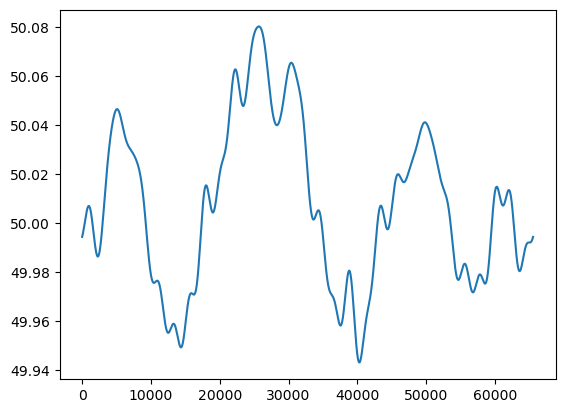

In [30]:
plt.plot(fft_frequency)

In [31]:
## Kalman

In [33]:
kalman_frequency = basic_filter(signal)

In [35]:
kalman_frequency

,Close,Outliers
0,50.009539,0
1,50.007856,0
2,50.007698,0
3,50.009250,0
4,50.007506,0
...,...,...
65530,49.979410,0
65531,49.982736,0
65532,49.981512,0
65533,49.982439,0


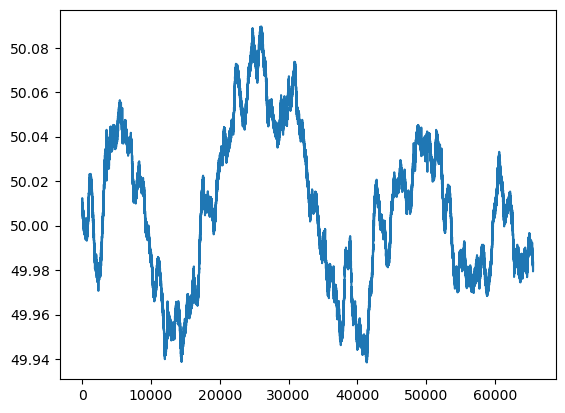

In [38]:
plt.plot(kalman_frequency['Close'])

In [42]:
wavelet_frequency = denoise_wavelet(signal, wavelet='db1', mode='soft', wavelet_levels=3, method='BayesShrink', rescale_sigma='True')

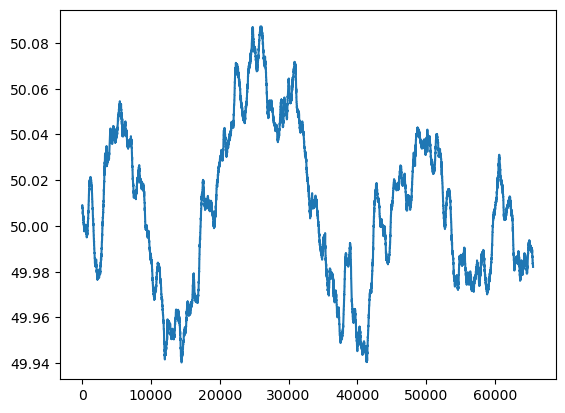

In [43]:
plt.plot(wavelet_frequency)

In [32]:
def basic_filter(data, mode='rolling', window=262, threshold=3):
    """Basic Filter.
    
    Mark as outliers the points that are out of the interval:
    (mean - threshold * std, mean + threshold * std ).
    
    Parameters
    ----------
    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series : pandas.DataFrame
        Original series and marked outliers.
    """
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

In [47]:
cleaned_frequency = fft_denoiser(freq_array, 00.1, to_real=True)

In [48]:
frequency['Cleaned frequency'] = cleaned_frequency

In [49]:
frequency.head()

,Timestamp,BADARPUR:Frequency,Cleaned frequency
0,2021-09-11 06:12:16.840,50.008,49.996235
1,2021-09-11 06:12:16.880,50.008,49.996248
2,2021-09-11 06:12:16.920,50.009,49.996262
3,2021-09-11 06:12:16.960,50.009,49.996275
4,2021-09-11 06:12:17.000,50.008,49.996289


##### Cleaned Frequency data

<AxesSubplot:>

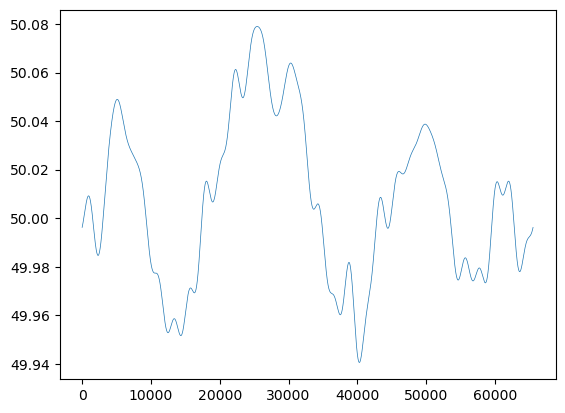

In [50]:
frequency['Cleaned frequency'].plot(linewidth = 0.5)

In [51]:
frequency_noise_analysis = frequency.copy()

In [52]:
frequency_noise_analysis['Noise'] = frequency_noise_analysis['BADARPUR:Frequency'] - frequency_noise_analysis['Cleaned frequency']

In [53]:
frequency_noise_analysis.head()

,Timestamp,BADARPUR:Frequency,Cleaned frequency,Noise
0,2021-09-11 06:12:16.840,50.008,49.996235,0.011765
1,2021-09-11 06:12:16.880,50.008,49.996248,0.011752
2,2021-09-11 06:12:16.920,50.009,49.996262,0.012738
3,2021-09-11 06:12:16.960,50.009,49.996275,0.012725
4,2021-09-11 06:12:17.000,50.008,49.996289,0.011711


### This is the noise in the signal

<AxesSubplot:>

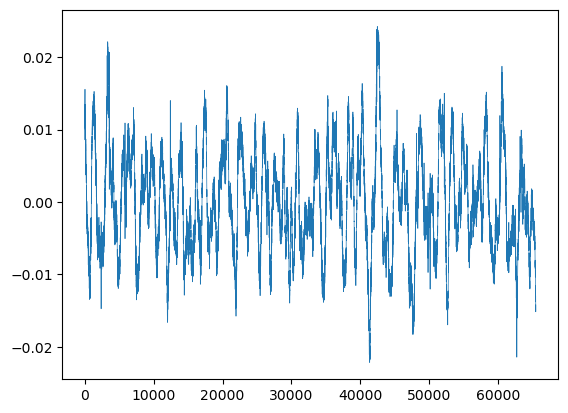

In [55]:
frequency_noise_analysis['Noise'].plot(linewidth = 0.5)

##### SNR

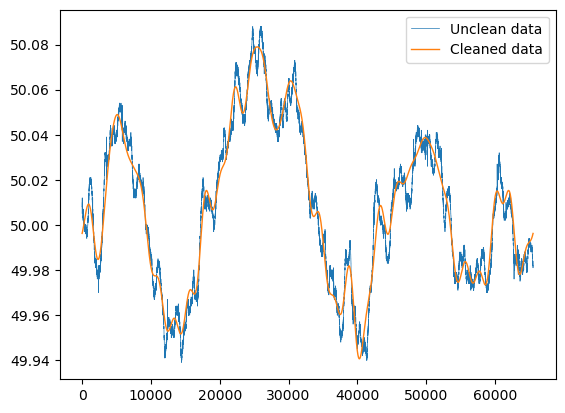

In [80]:
plt.plot(frequency_noise_analysis['BADARPUR:Frequency'], label = 'Unclean data', linewidth = 0.5)
plt.plot(frequency_noise_analysis['Cleaned frequency'], label = 'Cleaned data', linewidth = 1)
plt.legend()

#### SNR

[Check link for formula used](https://postimg.cc/LYK8t9XP)

In [77]:
snr = 20 * np.log10(np.mean(frequency_noise_analysis['BADARPUR:Frequency'])/np.std(frequency_noise_analysis['BADARPUR:Frequency']))

In [78]:
snr

63.35946464007045